## 2D implicit (backward Euler method)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import time

plt.rcParams.update({'font.size': 14})
from utilities import plot_phi, GS, residual


In [2]:
def applyBC(phi, Nx, Ny, S, L, H, convert_to_K=False):
    dx = L / (Nx - 1)  # Grid size
    dy = H / (Ny - 1)  # Grid size
    ## Right BC
    i = Nx - 1
    for j in range(1, Ny - 1):

        y = j * dy
        phiR = 1000 * (0.25 * np.sinh(0.5) + (y - 0.5) ** 2 * np.sinh(y - 0.5))

        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiR
            S[k] = phiR
        else:
            phi[i, j] = phiR
            S[i, j] = phiR

    ## left BC
    i = 0
    for j in range(1, Ny - 1):

        x = i * dx
        y = j * dy

        phiL = 1000 * (0.25 * np.sinh(-0.5) + (y - 0.5) ** 2 * np.sinh(y - 0.5))

        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiL
            S[k] = phiL
        else:
            phi[i, j] = phiL
            S[i, j] = phiL

            ## Bottom BC
    j = 0
    for i in range(Nx):

        x = i * dx
        y = j * dy

        phiB = 1000 * (0.25 * np.sinh(-0.5) + (x - 0.5) ** 2 * np.sinh(x - 0.5))
        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiB
            S[k] = phiB
        else:
            phi[i, j] = phiB
            S[i, j] = phiB

    ## Top BC
    j = Ny - 1
    for i in range(Nx):

        x = i * dx
        y = j * dy

        phiT = 1000 * (0.25 * np.sinh(0.5) + (x - 0.5) ** 2 * np.sinh(x - 0.5))

        if convert_to_K:
            k = (j - 1) * Nx + i
            phi[k] = phiT
            S[k] = phiT
        else:
            phi[i, j] = phiT
            S[i, j] = phiT

    return phi, S


def prepare_phi_and_S(Nx, Ny, L, H, convert_to_K=False):
    # Generate RHS source terms matrix and unknowns 'phi' with Dirichlet BCs
    S = np.zeros((Nx, Ny))
    phi = np.zeros((Nx, Ny))
    dx = L / (Nx - 1)  # Grid size
    dy = H / (Ny - 1)  # Grid size
    # RHS source terms
    for i in range(Nx):
        for j in range(Ny):
            x = i * dx
            y = j * dy

            source = 1000 * (
                    2 * np.sinh(x - 0.5) + 4 * (x - 0.5) * np.cosh(x - 0.5) + (x - 0.5) ** 2 * np.sinh(x - 0.5))
            + 1000 * (2 * np.sinh(y - 0.5) + 4 * (y - 0.5) * np.cosh(y - 0.5) + (y - 0.5) ** 2 * np.sinh(y - 0.5))

            S[i, j] = -source

    phi, S = applyBC(phi, Nx, Ny, S, L, H)

    return phi, S

In [3]:
# numbering scheme used is k = (j-1)*N + i
start = time.time()
Nx = 41
Ny = 41
L = 1  # length
H = 1  # length

dx = L / (Nx - 1)  # Grid size
dy = L / (Ny - 1)  # Grid size

t = 0
alpha = 1
tol = 1e-8
tmax = (0.5 / alpha) / (1 / dx ** 2 + 1 / dy ** 2)
dt = 5 * tmax

aE = -alpha / dx ** 2
aW = -alpha / dx ** 2
aN = -alpha / dy ** 2
aS = -alpha / dy ** 2
a0 = (1 / dt + 2 * alpha / dx ** 2 + 2 * alpha / dy ** 2)

phi_prev, S = prepare_phi_and_S(Nx, Ny, L, H)
# phi_next = applyBC(np.zeros(phi_prev.shape), Nx, Ny, S, L, H)

# RHS = -S + phi_prev / dt # New RHS for transient

for n in range(1000):
    RHS = S + phi_prev / dt
    for _ in tqdm(range(10000)):
        if _ == 0:
            phi_next = GS(Nx, Ny, phi_prev, RHS, aE, aW, aN, aS, a0)
            phi_next, __ = applyBC(phi_next, Nx, Ny, RHS, L, H)
        else:
            phi_next, __ = applyBC(phi_next, Nx, Ny, RHS, L, H)
            phi_next = GS(Nx, Ny, phi_next, RHS, aE, aW, aN, aS, a0)
            phi_next, __ = applyBC(phi_next, Nx, Ny, RHS, L, H)

        # Calculate residual
        R2, Rsum, R = residual(Nx, Ny, phi_next, RHS, aE, aW, aN, aS, a0)

        if _ % 1000 == 0:
            clear_output(True)
            print('Time: ', dt * n, 'n: ', n, 'Residual:', R2)

        if R2 < tol:
            print('Converged! Residual: ', R2, 'Time elapsed: ', time.time() - start)
            break
    phi_prev = phi_next

  0%|          | 0/10000 [00:00<?, ?it/s]

Time:  0.7804687500000002 n:  999 Residual: 3.92400675030472e-09
Converged! Residual:  3.92400675030472e-09 Time elapsed:  291.22115087509155


In [4]:
# # numbering scheme used is k = (j-1)*N + i
# start = time.time()
# Nx = 41
# Ny = 41
# L = 1   # length
# H = 1   # length


# dx = L/(Nx-1)    # Grid size
# dy = L/(Ny-1)    # Grid size

# tol = 1e-6
# aE = 1/dx**2
# aW = 1/dx**2
# aN = 1/dy**2
# aS = 1/dy**2
# a0 = -(2/dx**2 + 2/dy**2)

# phi, S = prepare_phi_and_S(Nx, Ny, L,H)

# for _ in tqdm(range(10000)):

#     for i in range(1,Nx-1):
#         for j in range(1,Ny-1):

#             # Gauss-Siedel Update
#             phi[i,j] = (S[i,j] - aE*phi[i+1,j] - aW*phi[i-1,j] - aN*phi[i,j+1] - aS*phi[i,j-1]) / a0

#     # Calculate residual
#     R2 = 0
#     R = np.zeros((Nx,Ny))

#     for i in range(1,Nx-1):    
#         for j in range(1,Ny-1):
#             R[i,j] = S[i,j] - aE*phi[i+1,j] - aW*phi[i-1,j] - aN*phi[i,j+1] - aS*phi[i,j-1] - a0*phi[i,j]
#             R2 = R2+R[i,j]**2

#     R2 = np.sqrt(R2)
#     if _ %500==0:
#         clear_output(True)
#         print('Residual:', R2)
        
#     if R2<tol:
#         print('Converged! Residual: ',R2, 'Time elapsed: ', time.time()-start)
#         break


<Figure size 432x288 with 0 Axes>

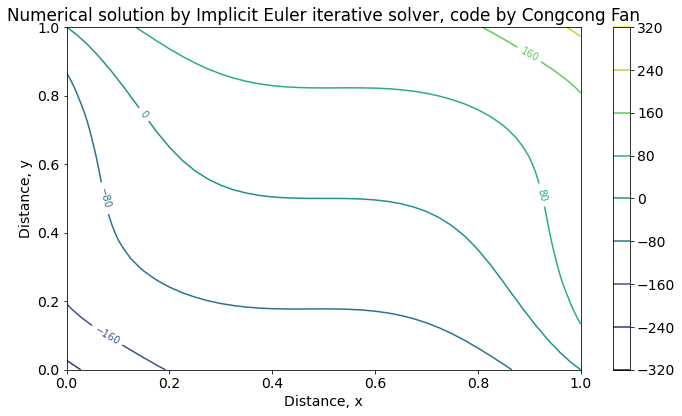

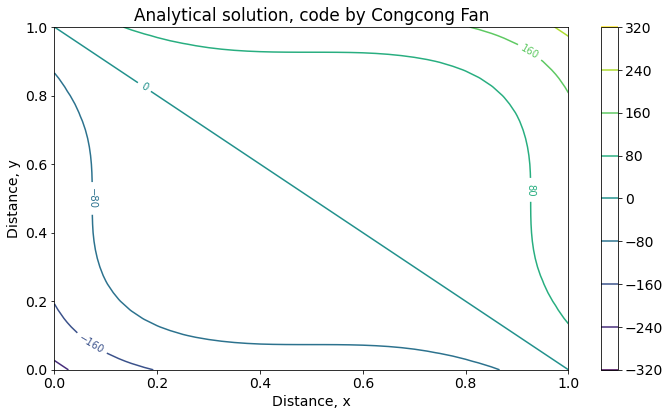

<Figure size 432x288 with 0 Axes>

In [6]:
# Analytical solution
x = np.linspace(0,1,Nx)
y = np.linspace(0,1,Ny)
phi_A = np.zeros((Nx,Ny))
for i in range(Nx):
    for j in range(Ny):
        
        phi_A[i,j] = 1000* ( (x[i]-0.5)**2*np.sinh(x[i]-0.5) + (y[j]-0.5)**2 * np.sinh(y[j]-0.5))

plot_phi(phi_prev, phi_A, Nx,Ny, 'Implicit Euler', convert=False)
plt.figure()
# plt.contour(x,y,phi)